In [25]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

In [26]:
# Importing data and creating a county dictionary

filename = 'GasStationDataSet_Partial.csv'
rawdat = pd.read_csv(filename)

counties = {
    22005: {'Name' : "Ascension", 'Population': 125061},
    22007: {'Name' : "Assumption", 'Population': 22236},
    22033: {'Name' : "East Baton Rouge", 'Population': 443158},
    22047: {'Name' : "Iberville", 'Population': 32626},
    22051: {'Name' : "Jefferson", 'Population': 434903},
    22057: {'Name' : "Lafourche", 'Population': 97980},
    22063: {'Name' : "Livingston", 'Population': 140524},
    22071: {'Name' : "Orleans", 'Population': 391249},
    22075: {'Name' : "Plaquemines", 'Population': 23305},
    22105: {'Name' : 'Tangipahoa', 'Population': 133753},
    22109: {'Name' : 'Terrebonne', 'Population': 111297},
    22117: {'Name' : 'Washington', 'Population': 46325}
    
}

In [27]:
# Organizing data into a standard datetime format

rawdat['time'] = [time.split(':')[0] + ':00' for time in rawdat['time']]
rawdat['datetime'] = pd.to_datetime(rawdat['date'] + ' ' + rawdat['time'])
rawdat.drop(['time','date'],axis=1,inplace=True)

outside = rawdat['FIPS']
inside = rawdat['datetime']
hier_index = list(zip(outside,inside))
hier_index = pd.MultiIndex.from_tuples(hier_index)
rawdat.set_index(hier_index, inplace=True)

rawdat.drop(['postalcode','datetime','FIPS','PercentageOperational'], axis=1, inplace=True)
rawdat.index.names = ['FIPS','datetime']

In [28]:
# Creating relevant features, dropping unimportant/bad features, organizing data
# Two final products: combined_county_data, and lateral_combined_data

data_by_county = {}
combined_county_data = pd.DataFrame()
lateral_combined_data = pd.DataFrame()
for FIP in counties:
    data_by_county[counties[FIP]['Name']] = rawdat.loc[FIP].groupby('datetime').sum()
    
    data_by_county[counties[FIP]['Name']]['FIPS'] = counties[FIP]['Name']
    data_by_county[counties[FIP]['Name']]['PercentageOperational'] = data_by_county[counties[FIP]['Name']]['Has Fuel:Has Power']/data_by_county[counties[FIP]['Name']]['Total Stations']
    data_by_county[counties[FIP]['Name']]['1 Day Moving Avg PercentageOperational'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=3).mean()
    data_by_county[counties[FIP]['Name']]['2 Day Moving Avg PercentageOperational'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=6).mean()
    data_by_county[counties[FIP]['Name']]['3 Day Moving Avg PercentageOperational'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=9).mean()
    data_by_county[counties[FIP]['Name']]['2 Day Minimum'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=6).min()
    data_by_county[counties[FIP]['Name']]['3 Day Minimum'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=9).min()
    data_by_county[counties[FIP]['Name']]['2 Day Maximum'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=6).max()
    data_by_county[counties[FIP]['Name']]['3 Day Maximum'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=9).max()
    data_by_county[counties[FIP]['Name']]['1 Day Std'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=3).std()
    data_by_county[counties[FIP]['Name']]['2 Day Std'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=6).std()
    data_by_county[counties[FIP]['Name']]['3 Day Std'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=9).std()
    data_by_county[counties[FIP]['Name']].drop(columns=['Total Stations', 'Has Fuel:Has Power', 'Has Fuel:No Power', 'No Fuel:Has Power', 'No Power:No Fuel', 'raw_visit_counts'], inplace=True)
    combined_county_data = pd.concat([combined_county_data, data_by_county[counties[FIP]['Name']]])

    data_by_county[counties[FIP]['Name']].drop(columns=['FIPS'],axis=1,inplace=True)
    data_by_county[counties[FIP]['Name']].columns = [ str(counties[FIP]['Name']) + ' ' + name for name in list(data_by_county[counties[FIP]['Name']])]
    lateral_combined_data = pd.concat([lateral_combined_data, data_by_county[counties[FIP]['Name']]], axis=1)

In [29]:
# Create target variable as the percentage operational, 3 data points (24 hours) ahead
# Split data into train and test sets

lateral_combined_data.dropna(inplace=True)
y = lateral_combined_data['Ascension PercentageOperational'].iloc[3:]
X = lateral_combined_data[:-3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [30]:
# Create a linear regression model as baseline
results = {}

LR = LinearRegression()
LR.fit(X_train,y_train)

LR_pred_train = LR.predict(X_train)
MAE = metrics.mean_absolute_error(y_train,LR_pred_train)
MSE = metrics.mean_squared_error(y_train,LR_pred_train)
RMSE = metrics.mean_squared_error(y_train,LR_pred_train, squared=False)
print('\nLinear Regression Training Performance:')
print(f'MAE = {MAE}')
print(f'MSE = {MSE}')
print(f'RMSE = {RMSE}')

LR_pred = LR.predict(X_test)
test_MAE = metrics.mean_absolute_error(y_test,LR_pred)
test_MSE = metrics.mean_squared_error(y_test,LR_pred)
test_RMSE = metrics.mean_squared_error(y_test,LR_pred, squared=False)
print('\nLinear Regression Testing Performance:')
print(f'MAE = {test_MAE}')
print(f'MSE = {test_MSE}')
print(f'RMSE = {test_RMSE}')

results['LinearRegression'] = [MAE, MSE, RMSE, test_MAE, test_MSE, test_RMSE]


Linear Regression Training Performance:
MAE = 2.661983022262157e-15
MSE = 1.1731755768270672e-29
RMSE = 3.4251650716820456e-15

Linear Regression Testing Performance:
MAE = 0.07903958346221916
MSE = 0.03268664624093414
RMSE = 0.18079448620169294


In [31]:
# Try Ridge Regression with different Alpha params

train_error_RMSE = []
test_error_RMSE = []
train_error_MAE = []
test_error_MAE = []
i = [0.00001, 0.0001, 0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

for alpha in i:
    
    clf = Ridge(alpha=alpha)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_train)
    MAE = metrics.mean_absolute_error(y_train,y_pred)
    MSE = metrics.mean_squared_error(y_train,y_pred)
    RMSE = metrics.mean_squared_error(y_train,y_pred, squared=False)
    train_error_RMSE.append(RMSE)
    train_error_MAE.append(MAE)

    y_pred_test = clf.predict(X_test)
    MAE = metrics.mean_absolute_error(y_test,y_pred_test)
    MSE = metrics.mean_squared_error(y_test,y_pred_test)
    RMSE = metrics.mean_squared_error(y_test,y_pred_test, squared=False)
    test_error_RMSE.append(RMSE)
    test_error_MAE.append(MAE)

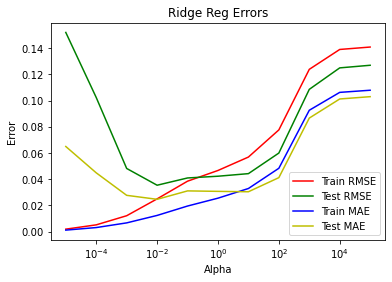

In [32]:
# Choose a good Alpha param (alpha=10 appears good)

plt.plot(i, train_error_RMSE, color='r', label='Train RMSE')
plt.plot(i, test_error_RMSE, color='g', label='Test RMSE')
plt.plot(i, train_error_MAE, color='b', label='Train MAE')
plt.plot(i, test_error_MAE, color='y', label='Test MAE')
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.title("Ridge Reg Errors")
plt.legend()
plt.xscale('log')

In [33]:
# Best Ridge model

clf = Ridge(alpha=10)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
MAE = metrics.mean_absolute_error(y_train,y_pred)
MSE = metrics.mean_squared_error(y_train,y_pred)
RMSE = metrics.mean_squared_error(y_train,y_pred, squared=False)
print('\nRidge Regression Training Performance:')
print(f'MAE = {MAE}')
print(f'MSE = {MSE}')
print(f'RMSE = {RMSE}')

y_pred_test = clf.predict(X_test)
test_MAE = metrics.mean_absolute_error(y_test,y_pred_test)
test_MSE = metrics.mean_squared_error(y_test,y_pred_test)
test_RMSE = metrics.mean_squared_error(y_test,y_pred_test, squared=False)
print('\nRidge Regression Testing Performance:')
print(f'MAE = {test_MAE}')
print(f'MSE = {test_MSE}')
print(f'RMSE = {test_RMSE}')

results['RidgeRegression'] = [MAE, MSE, RMSE, test_MAE, test_MSE, test_RMSE]


Ridge Regression Training Performance:
MAE = 0.03288054199662935
MSE = 0.0032374611843414983
RMSE = 0.05689869229025829

Ridge Regression Testing Performance:
MAE = 0.03039592001998399
MSE = 0.001956480210004106
RMSE = 0.04423211740358024


In [34]:
#Try Lasso Regression with different Alpha params

train_error_RMSE = []
test_error_RMSE = []
train_error_MAE = []
test_error_MAE = []
i = [0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

for alpha in i:
    
    lasso = Lasso(alpha=alpha, max_iter=10000000)
    lasso.fit(X_train, y_train)
    
    y_pred = lasso.predict(X_train)
    MAE = metrics.mean_absolute_error(y_train,y_pred)
    MSE = metrics.mean_squared_error(y_train,y_pred)
    RMSE = metrics.mean_squared_error(y_train,y_pred, squared=False)
    train_error_RMSE.append(RMSE)
    train_error_MAE.append(MAE)

    y_pred_test = lasso.predict(X_test)
    MAE = metrics.mean_absolute_error(y_test,y_pred_test)
    MSE = metrics.mean_squared_error(y_test,y_pred_test)
    RMSE = metrics.mean_squared_error(y_test,y_pred_test, squared=False)
    test_error_RMSE.append(RMSE)
    test_error_MAE.append(MAE)  

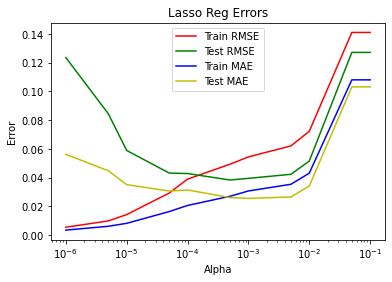

In [44]:
#Choose a good Alpha param (alpha=0.0007 is good)

plt.plot(i, train_error_RMSE, color='r', label='Train RMSE')
plt.plot(i, test_error_RMSE, color='g', label='Test RMSE')
plt.plot(i, train_error_MAE, color='b', label='Train MAE')
plt.plot(i, test_error_MAE, color='y', label='Test MAE')
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.title("Lasso Reg Errors")
plt.legend()
plt.xscale('log')

In [45]:
# Best Lasso Model

lasso = Lasso(alpha=0.002)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_train)
MAE = metrics.mean_absolute_error(y_train,y_pred)
MSE = metrics.mean_squared_error(y_train,y_pred)
RMSE = metrics.mean_squared_error(y_train,y_pred, squared=False)
print('\nLasso Regression Training Performance:')
print(f'MAE = {MAE}')
print(f'MSE = {MSE}')
print(f'RMSE = {RMSE}')

y_pred_test = lasso.predict(X_test)
test_MAE = metrics.mean_absolute_error(y_test,y_pred_test)
test_MSE = metrics.mean_squared_error(y_test,y_pred_test)
test_RMSE = metrics.mean_squared_error(y_test,y_pred_test, squared=False)
print('\nLasso Regression Training Performance:')
print(f'MAE = {test_MAE}')
print(f'MSE = {test_MSE}')
print(f'RMSE = {test_RMSE}')

results['LassoRegression'] = [MAE, MSE, RMSE, test_MAE, test_MSE, test_RMSE]


Lasso Regression Training Performance:
MAE = 0.03780333649571857
MSE = 0.0037256909467294225
RMSE = 0.0610384382723659

Lasso Regression Training Performance:
MAE = 0.03510280860763454
MSE = 0.00218225544024323
RMSE = 0.046714616987012


In [46]:
# import requests
# # from bs4 import BeautifulSoup
# from urllib.request import urlopen
# import json
# import plotly.express as px

# with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
#     counties = json.load(response)
    
# fig = px.choropleth(combined_county_data, geojson=counties,
#                    locations='FIPS',
#                    color='PercentageOperational',
#                     animation_frame=[str(x) for x in combined_county_data.index],
#                    color_continuous_scale='rdylgn',
#                    scope='usa',
#                    range_color=(0,1),
#                    title="Fuel Forecast")

# fig.update_geos(fitbounds='locations', visible=False)
# fig.show()

In [47]:
# Try PCA with 3 principal components
# Scale data first for PCA

scaler = StandardScaler()
scaler.fit(X)
scaled_data = scaler.transform(X)

pca = PCA(n_components=3)
pca.fit(scaled_data)
X_pca = pca.transform(scaled_data)

# Split data using PCA features
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=101)

# Perform Linear Regression using PCA features
LR = LinearRegression()
LR.fit(X_train,y_train)

LR_pred = LR.predict(X_train)
MAE = metrics.mean_absolute_error(y_train,LR_pred)
MSE = metrics.mean_squared_error(y_train,LR_pred)
RMSE = metrics.mean_squared_error(y_train,LR_pred, squared=False)
print('PCA error metrics:')
print(f'MAE = {MAE}')
print(f'MSE = {MSE}')
print(f'RMSE = {RMSE}')

LR_pred = LR.predict(X_test)
test_MAE = metrics.mean_absolute_error(y_test,LR_pred)
test_MSE = metrics.mean_squared_error(y_test,LR_pred)
test_RMSE = metrics.mean_squared_error(y_test,LR_pred, squared=False)
print('PCA error metrics:')
print(f'MAE = {test_MAE}')
print(f'MSE = {test_MSE}')
print(f'RMSE = {test_RMSE}')

results['PCA_LinReg'] = [MAE, MSE, RMSE, test_MAE, test_MSE, test_RMSE]

PCA error metrics:
MAE = 0.03784214662359749
MSE = 0.003725023717452125
RMSE = 0.06103297237929777
PCA error metrics:
MAE = 0.03496291544637937
MSE = 0.0021690432349506035
RMSE = 0.046572988254465736


<AxesSubplot:>

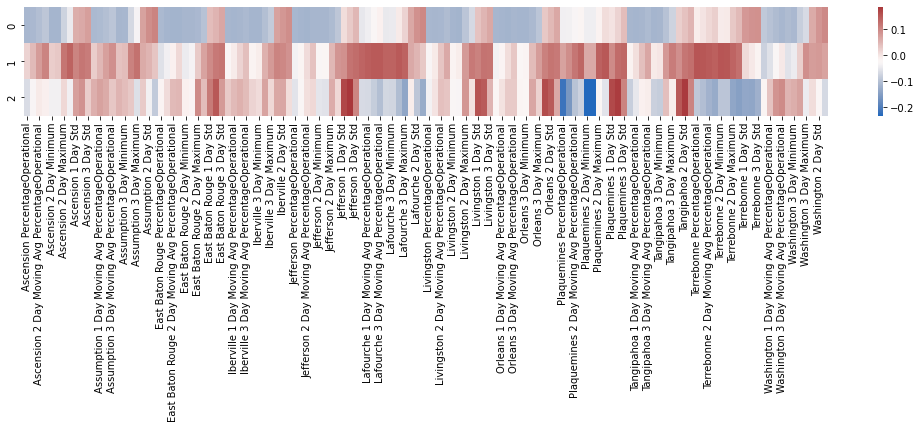

In [48]:
# Visualize component weights

df_comp = pd.DataFrame(pca.components_,columns=X.columns)
plt.figure(figsize=(18,2))
sns.heatmap(df_comp, cmap='vlag')

In [49]:
#PCA component weights

coeffecients = pd.DataFrame(np.transpose(pca.components_),X.columns)
coeffecients.columns = ['1st Component', '2nd Component', '3rd Component']
coeffecients

,1st Component,2nd Component,3rd Component
Ascension PercentageOperational,-0.113871,0.018960,-0.063910
Ascension 1 Day Moving Avg PercentageOperational,-0.112142,0.044869,-0.030430
Ascension 2 Day Moving Avg PercentageOperational,-0.103997,0.078363,-0.004504
Ascension 3 Day Moving Avg PercentageOperational,-0.091917,0.103652,-0.011092
Ascension 2 Day Minimum,-0.117352,0.024981,-0.037734
...,...,...,...
Washington 2 Day Maximum,-0.081934,0.023913,0.071642
Washington 3 Day Maximum,-0.065406,0.090156,-0.044104
Washington 1 Day Std,0.061854,0.076183,0.008347
Washington 2 Day Std,0.084387,0.079653,-0.024207


[Text(0.5, 0, '3rd Component'), Text(0, 0.5, '1st Component')]

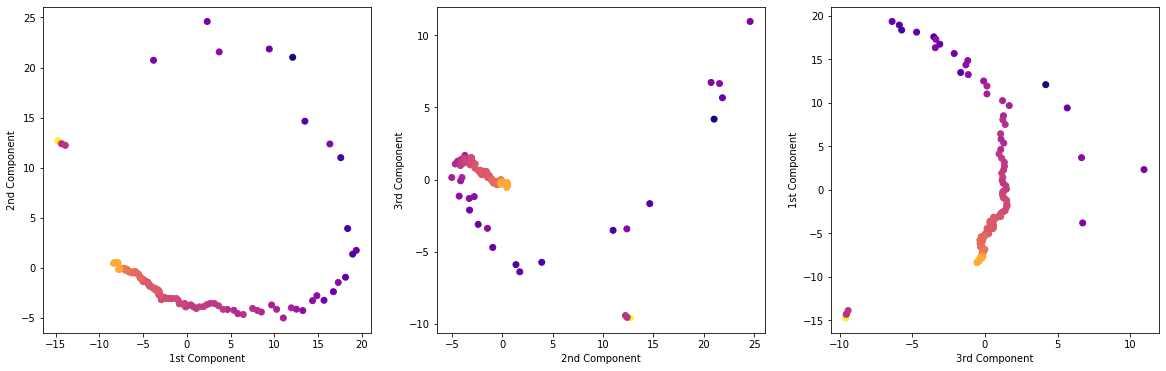

In [50]:
#PCA Component visualization

f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,6))
ax1.scatter(X_pca[:,0],X_pca[:,1], c=y, cmap='plasma')
ax1.set(xlabel='1st Component', ylabel='2nd Component')
ax2.scatter(X_pca[:,1],X_pca[:,2], c=y, cmap='plasma')
ax2.set(xlabel='2nd Component', ylabel='3rd Component')
ax3.scatter(X_pca[:,2],X_pca[:,0], c=y, cmap='plasma')
ax3.set(xlabel='3rd Component', ylabel='1st Component')

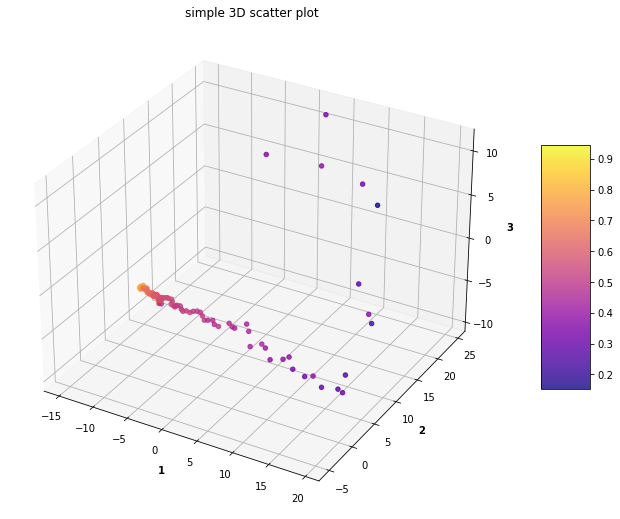

In [51]:
# More PCA visualization 

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
my_cmap = plt.get_cmap('plasma')
 
sctt = ax.scatter3D(X_pca[:,0], X_pca[:,1], X_pca[:,2],
                    alpha = 0.8,
                    c = y,
                    cmap = my_cmap,)
 
plt.title("simple 3D scatter plot")
ax.set_xlabel('1', fontweight ='bold')
ax.set_ylabel('2', fontweight ='bold')
ax.set_zlabel('3', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

In [52]:
# Results as percentages

results_df = (pd.DataFrame(results)*100).round(2)
results_df.index = ['Train MAE', 'Train MSE', 'Train RMSE', 'Test MAE', 'Test MSE', 'Test RMSE']
results_df.transpose()

,Train MAE,Train MSE,Train RMSE,Test MAE,Test MSE,Test RMSE
LinearRegression,0.00,0.00,0.00,7.90,3.27,18.08
RidgeRegression,3.29,0.32,5.69,3.04,0.20,4.42
PCA_LinReg,3.78,0.37,6.10,3.50,0.22,4.66
LassoRegression,3.78,0.37,6.10,3.51,0.22,4.67
